<a href="https://colab.research.google.com/github/vggls/Feature_extraction_with_Conv_Autoencoders/blob/main/autoencoder_training_and_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load the spectograms_of_unlabelled_data.pickle file stored in the root of Google Drive
with open("/content/drive/MyDrive/spectograms_of_unlabelled_data.pickle", "rb") as f:
    x_train_ae = pickle.load(f)
x_train_ae.shape

(11300, 74, 200, 1)

In [ ]:
#upload autoencoders.py in the content folder of Google Colab and run the below
from autoencoders import autoencoder_1, autoencoder_2, autoencoder_3, autoencoder_4

**Remark on the autoencoder.py file imported above**

The autoencoders.py contains 4 different symmetric convolutional autoencoder architectures, named 'autoencoder_1', 'autoencoder_2', 'autoencoder_3' and 'autoencoder_4'.

The "tune_autoencoder" function, runs 8 (2^3) training experiments per autoencoder architecture for different latent dimension (bottleneck dimension), Adam's learning rate and training batch size. It plots the loss history of each hyperparameter combination and stores the respective encoder model.

**Remark on the loss choice**

Note that initially the MSE loss was tested. However, it didn't train well and thus we looked for alternatives. Eventually, the Binary Crossentropy was chosen, as per below sources :

- https://blog.keras.io/building-autoencoders-in-keras.html  (Keras Tutorial)

- https://yaledatascience.github.io/2016/10/29/autoencoders.html

- https://github.com/nlinc1905/Convolutional-Autoencoder-Music-Similarity/blob/master/03_autoencoding_and_tsne.py

- https://stackoverflow.com/questions/52441877/how-does-binary-cross-entropy-loss-work-on-autoencoders

- https://stats.stackexchange.com/questions/370179/why-binary-crossentropy-can-be-used-as-the-loss-function-in-autoencoders

- https://stackoverflow.com/questions/61614366/convolutional-autoencoders

In [ ]:
def tune_autoencoder(x_train_ae, ae_architecture):
    
    '''
    PARAMETERS
    x_train_ae : The training data for the autoencoders. Should be of shape (None, 74, 200, 1).
    ae_architecture : An autoencoder function, as included in the autoencoders.py, parametrized for the latent_dim.
                      Each function returns first the autoencoder and then the encoder.
    RETURNS
    Nothing. While compiling it saves the encoders and eventually prints the loss history of each hyperparameter combination.
    '''    
    
    #plf.figure(figsize=(20, 8))

    fig, ax = plt.subplots(2, 4, figsize=(20,8)) 
    fig.suptitle("Loss History")

    for i, latent_dim in enumerate([64, 128]): #could try more, but Colab's RAM runs out
      autoencoder, encoder = ae_architecture(latent_dim)
      j = 0
      for learning_rate in [0.001, 0.005]: #higher learning rate values such are 0.01, 0.5 and 1 train bad
        for optimizer in [keras.optimizers.Adam(learning_rate=learning_rate)]: #SGD trains bad
          for loss in ['binary_crossentropy']: #mse deliberately left out.. does not train well.. 10^-4 train/val scores from 1st epoch
            for batch_size in [128, 256]:
              
              encoder.compile(optimizer=optimizer, loss=loss)
              autoencoder.compile(optimizer=optimizer, loss=loss)

              earlystopping = EarlyStopping(monitor="val_loss", min_delta=0.001, patience=30, verbose=0)
              history = autoencoder.fit(x_train_ae, x_train_ae, 
                                          epochs=100, 
                                          verbose=0, 
                                          batch_size=batch_size, 
                                          shuffle = True,
                                          validation_split=0.3,
                                          callbacks=[earlystopping])
              encoder.save('encoder-latent_dim:{}-l_rate:{}-batch:{}.h5'.format(latent_dim, learning_rate, batch_size))

              epochs = len(history.history['loss'])
              x = range(1, epochs+1)
              ax[i, j].plot(x, history.history['loss'])
              ax[i, j].plot(x, history.history['val_loss'])
              ax[i, j].legend(['train', 'validation '])
              ax[i, j].set_title("latent_dim:{}-l_rate:{}-batch:{}".format(latent_dim, learning_rate, batch_size))
              
              j+=1
              
              print('Training of model with latent_dim:{}, learning_rate:{}, batch_size:{} has ended'.\
                    format(latent_dim, learning_rate, batch_size))

             

**Architecture No.1 (autoencoder_1)**

Training of model with latent_dim:64, learning_rate:0.001, batch_size:128 has ended
Training of model with latent_dim:64, learning_rate:0.001, batch_size:256 has ended
Training of model with latent_dim:64, learning_rate:0.005, batch_size:128 has ended
Training of model with latent_dim:64, learning_rate:0.005, batch_size:256 has ended
Training of model with latent_dim:128, learning_rate:0.001, batch_size:128 has ended
Training of model with latent_dim:128, learning_rate:0.001, batch_size:256 has ended
Training of model with latent_dim:128, learning_rate:0.005, batch_size:128 has ended
Training of model with latent_dim:128, learning_rate:0.005, batch_size:256 has ended


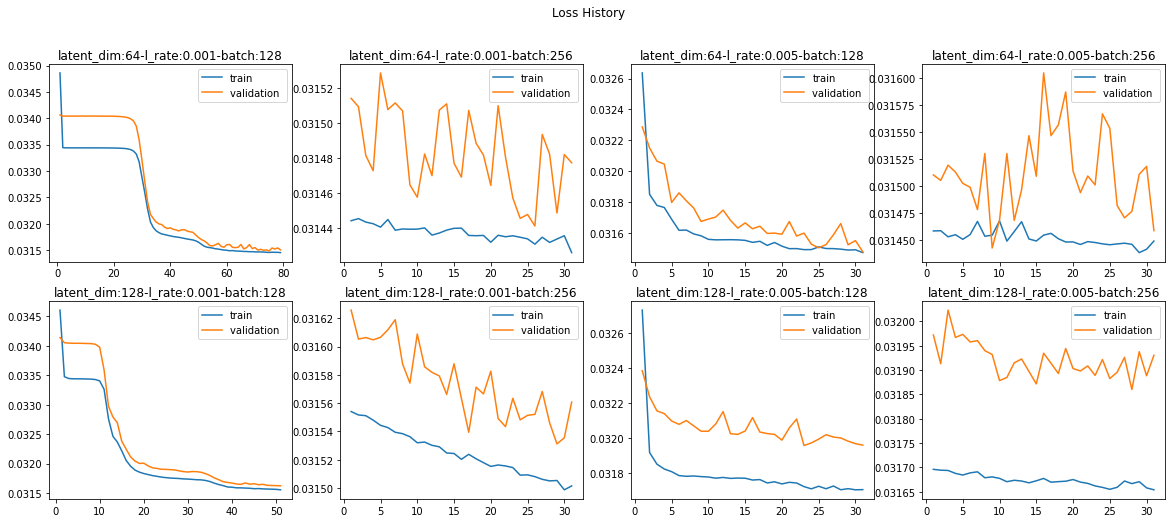

In [ ]:
tune_autoencoder(x_train_ae, autoencoder_1)

We keep the encoder of the autoencoder with latent dim 128, learning rate 0.001 and training batch size 128.

In [ ]:
# summary of the chosen encoder
autoencoder_1(128)[1].summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 74, 200, 1)]      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 37, 100, 2)        10        
                                                                 
 dropout_12 (Dropout)        (None, 37, 100, 2)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 9, 25, 8)          264       
                                                                 
 dropout_13 (Dropout)        (None, 9, 25, 8)          0         
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 12, 8)          264       
                                                                 
 flatten_2 (Flatten)         (None, 384)               0   

**Architecture No.2 (autoencoder_2)**

Training of model with latent_dim:64, learning_rate:0.001, batch_size:128 has ended
Training of model with latent_dim:64, learning_rate:0.001, batch_size:256 has ended
Training of model with latent_dim:64, learning_rate:0.005, batch_size:128 has ended
Training of model with latent_dim:64, learning_rate:0.005, batch_size:256 has ended
Training of model with latent_dim:128, learning_rate:0.001, batch_size:128 has ended
Training of model with latent_dim:128, learning_rate:0.001, batch_size:256 has ended
Training of model with latent_dim:128, learning_rate:0.005, batch_size:128 has ended
Training of model with latent_dim:128, learning_rate:0.005, batch_size:256 has ended


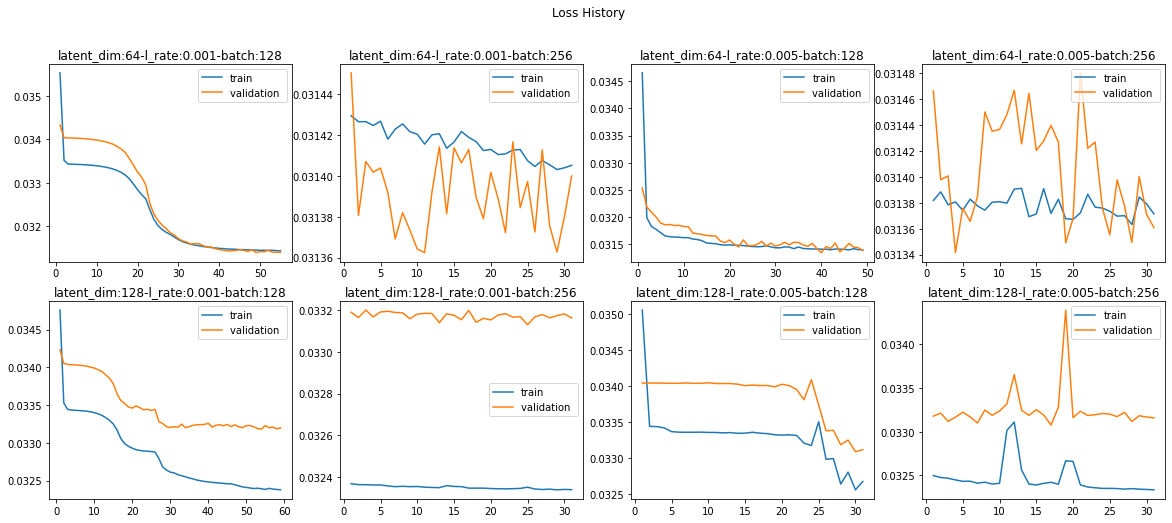

In [ ]:
tune_autoencoder(x_train_ae, autoencoder_2)

We keep the encoder of the autoencoder with latent dim 64, learning rate 0.005 and training batch size 128.

In [ ]:
# summary of the chosen encoder
autoencoder_2(64)[1].summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 74, 200, 1)]      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 37, 100, 2)        10        
                                                                 
 dropout_16 (Dropout)        (None, 37, 100, 2)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 18, 49, 4)         76        
                                                                 
 dropout_17 (Dropout)        (None, 18, 49, 4)         0         
                                                                 
 conv2d_13 (Conv2D)          (None, 9, 24, 8)          136       
                                                                 
 dropout_18 (Dropout)        (None, 9, 24, 8)          0   

**Architecture No.3 (autoencoder_3)**

Training of model with latent_dim:64, learning_rate:0.001, batch_size:128 has ended
Training of model with latent_dim:64, learning_rate:0.001, batch_size:256 has ended
Training of model with latent_dim:64, learning_rate:0.005, batch_size:128 has ended
Training of model with latent_dim:64, learning_rate:0.005, batch_size:256 has ended
Training of model with latent_dim:128, learning_rate:0.001, batch_size:128 has ended
Training of model with latent_dim:128, learning_rate:0.001, batch_size:256 has ended
Training of model with latent_dim:128, learning_rate:0.005, batch_size:128 has ended
Training of model with latent_dim:128, learning_rate:0.005, batch_size:256 has ended


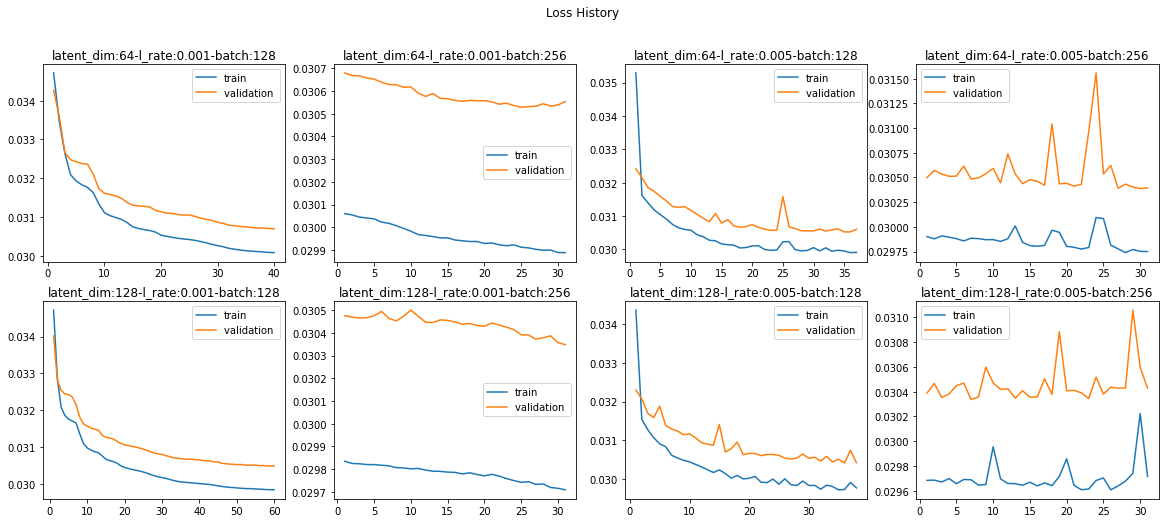

In [ ]:
tune_autoencoder(x_train_ae, autoencoder_3)

The autoencoders with learning rate 0.01 and training batch size 128 are equivalent. One might consider keeping any of those two.

In [ ]:
# summary of the chosen encoder
autoencoder_3(64)[1].summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 74, 200, 1)]      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 37, 100, 16)       80        
                                                                 
 dropout_24 (Dropout)        (None, 37, 100, 16)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 18, 50, 32)        2080      
                                                                 
 dropout_25 (Dropout)        (None, 18, 50, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 6, 16, 64)         18496     
                                                                 
 dropout_26 (Dropout)        (None, 6, 16, 64)         0   

**Architecture No.4 (autoencoder_4)**

Training of model with latent_dim:64, learning_rate:0.001, batch_size:128 has ended
Training of model with latent_dim:64, learning_rate:0.001, batch_size:256 has ended
Training of model with latent_dim:64, learning_rate:0.005, batch_size:128 has ended
Training of model with latent_dim:64, learning_rate:0.005, batch_size:256 has ended
Training of model with latent_dim:128, learning_rate:0.001, batch_size:128 has ended
Training of model with latent_dim:128, learning_rate:0.001, batch_size:256 has ended
Training of model with latent_dim:128, learning_rate:0.005, batch_size:128 has ended
Training of model with latent_dim:128, learning_rate:0.005, batch_size:256 has ended


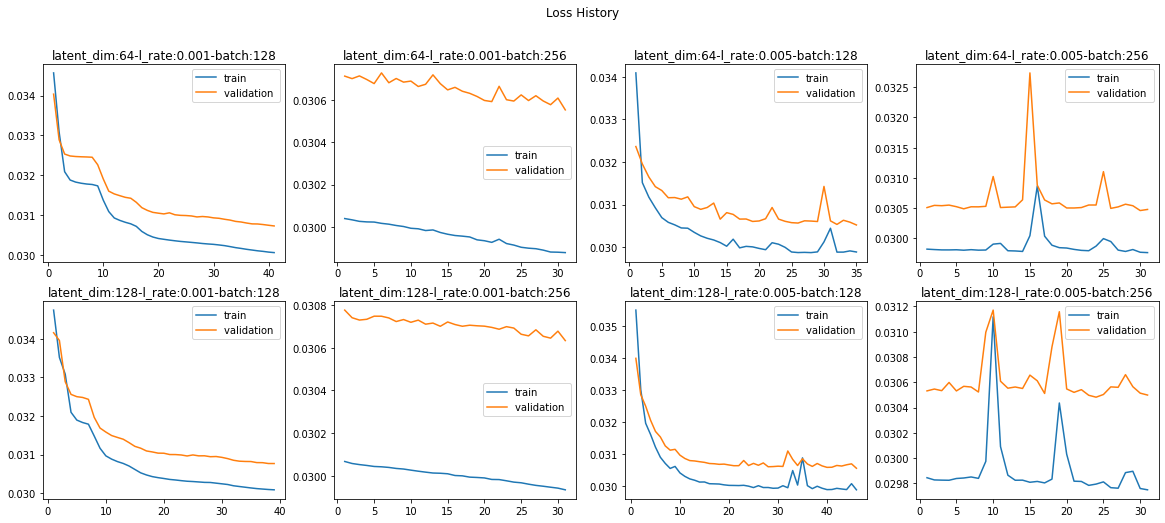

In [ ]:
tune_autoencoder(x_train_ae, autoencoder_4)

The autoencoders with learning rate 0.01 and training batch size 128 are equivalent. One might consider keeping any of those two.

In [ ]:
# summary of the chosen encoder
autoencoder_4(64)[1].summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 74, 200, 1)]      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 36, 99, 8)         136       
                                                                 
 dropout_12 (Dropout)        (None, 36, 99, 8)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 17, 49, 16)        1168      
                                                                 
 dropout_13 (Dropout)        (None, 17, 49, 16)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 24, 32)         2080      
                                                                 
 dropout_14 (Dropout)        (None, 8, 24, 32)         0   

**Which encoder to choose for the experiments?**

Recall that so far we have saved the best encoder from each architecture. In order to choose the final one we have to take into account the loss values of the learned autoencoders and the encoder complexity.



*   Architecture No. 1 : Autoencoder Loss 0.0315, Val_Loss 0.0316, Encoder Complexity 49,818 params
*   Architecture No. 2 : Autoencoder Loss 0.0315, Val_Loss 0.0315, Encoder Complexity 49,966 params
*   Architecture No. 3 : Autoencoder Loss 0.03, Val_Loss 0.0305, Encoder Complexity 438,896 params
*   Architecture No. 4 : Autoencoder Loss 0.03, Val_Loss 0.031, Encoder Complexity 814,776 params

The last two architectures seem to perform a bit better. Their complexity is largers and this is not be desired in general, but the complexity of the **architecure no. 3 encoder** is managable. Thus we will use it for our experiments.

(Note that for the same experiments encoder of arch no.2 was tested as well. However, encoder of arch no.3 gives results that seem to be more "expected" under some classifier choices and consequently was prefered. Encoder 2 is also uploaded in github though.)